In [74]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models import MLP
from data import get_data_classif, get_dataloader, regr_true_func

import matplotlib.pyplot as plt

import numpy as np
from curvlinops import HessianLinearOperator, GGNLinearOperator
from torch.distributions.multivariate_normal import _precision_to_scale_tril
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from copy import deepcopy

from laplace import Laplace

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [75]:
DIMENSIONS = [1, 16, 16]
LR = 0.1
WD = 1e-6
EPOCHS = 1000

# generate data
n_samples = 20
x_train = np.random.uniform(-3, 3, n_samples)
y_train = regr_true_func(x_train) + np.random.normal(0, 0.1, n_samples)

### Laplace Approximation

In [76]:
# train single net
torch.manual_seed(0)
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(x_train, dtype=torch.float32).unsqueeze(1),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    ),
    batch_size=n_samples, shuffle=False
)
net = MLP(*DIMENSIONS, output_type="numeric", dropout_rate=0)
net.train(
    train_loader, n_epochs=EPOCHS, lr=LR, weight_decay=WD,
    milestones=[2000], gamma=1, # turn off learning rate decay
    seed=1, log_interval=100
)

# perform last-layer LA with KFAC
la = Laplace(net.model, "regression")
la.fit(train_loader)
la.optimize_prior_precision("glm")

Epoch 100/1000, Training Loss: 0.038655, Accuracy: nan
Epoch 200/1000, Training Loss: 0.023368, Accuracy: nan
Epoch 300/1000, Training Loss: 0.016275, Accuracy: nan
Epoch 400/1000, Training Loss: 0.013468, Accuracy: nan
Epoch 500/1000, Training Loss: 0.012054, Accuracy: nan
Epoch 600/1000, Training Loss: 0.018640, Accuracy: nan
Epoch 700/1000, Training Loss: 0.014442, Accuracy: nan
Epoch 800/1000, Training Loss: 0.013447, Accuracy: nan
Epoch 900/1000, Training Loss: 0.013332, Accuracy: nan
Epoch 1000/1000, Training Loss: 0.013298, Accuracy: nan


### Deep Ensemble

In [77]:
# generate data
torch.manual_seed(0)
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(x_train, dtype=torch.float32).unsqueeze(1),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    ),
    batch_size=20, shuffle=False
)
ensemble_size = 10
ensemble = []
for i in range(ensemble_size):
    print("===========")
    print(f"Training model {i}")
    torch.manual_seed(i)
    net = MLP(*DIMENSIONS, output_type="numeric", dropout_rate=0)
    net.train(
        train_loader, n_epochs=EPOCHS, lr=LR, weight_decay=WD,
        milestones=[2000], gamma=1, # turn off learning rate decay
        seed=1, log_interval=100
    )
    ensemble.append(net)

Training model 0
Epoch 100/1000, Training Loss: 0.038655, Accuracy: nan
Epoch 200/1000, Training Loss: 0.023368, Accuracy: nan
Epoch 300/1000, Training Loss: 0.016275, Accuracy: nan
Epoch 400/1000, Training Loss: 0.013468, Accuracy: nan
Epoch 500/1000, Training Loss: 0.012054, Accuracy: nan
Epoch 600/1000, Training Loss: 0.018640, Accuracy: nan
Epoch 700/1000, Training Loss: 0.014442, Accuracy: nan
Epoch 800/1000, Training Loss: 0.013447, Accuracy: nan
Epoch 900/1000, Training Loss: 0.013332, Accuracy: nan
Epoch 1000/1000, Training Loss: 0.013298, Accuracy: nan
Training model 1
Epoch 100/1000, Training Loss: 0.027826, Accuracy: nan
Epoch 200/1000, Training Loss: 0.017399, Accuracy: nan
Epoch 300/1000, Training Loss: 0.013083, Accuracy: nan
Epoch 400/1000, Training Loss: 0.011047, Accuracy: nan
Epoch 500/1000, Training Loss: 0.009892, Accuracy: nan
Epoch 600/1000, Training Loss: 0.009203, Accuracy: nan
Epoch 700/1000, Training Loss: 0.010253, Accuracy: nan
Epoch 800/1000, Training Loss:

### MC Dropout

Epoch 100/2000, Training Loss: 0.099555, Accuracy: nan
Epoch 200/2000, Training Loss: 0.067150, Accuracy: nan
Epoch 300/2000, Training Loss: 0.067494, Accuracy: nan
Epoch 400/2000, Training Loss: 0.068815, Accuracy: nan
Epoch 500/2000, Training Loss: 0.059924, Accuracy: nan
Epoch 600/2000, Training Loss: 0.068080, Accuracy: nan
Epoch 700/2000, Training Loss: 0.035008, Accuracy: nan
Epoch 800/2000, Training Loss: 0.093730, Accuracy: nan
Epoch 900/2000, Training Loss: 0.056424, Accuracy: nan
Epoch 1000/2000, Training Loss: 0.027819, Accuracy: nan
Epoch 1100/2000, Training Loss: 0.048704, Accuracy: nan
Epoch 1200/2000, Training Loss: 0.069681, Accuracy: nan
Epoch 1300/2000, Training Loss: 0.054984, Accuracy: nan
Epoch 1400/2000, Training Loss: 0.052878, Accuracy: nan
Epoch 1500/2000, Training Loss: 0.048041, Accuracy: nan
Epoch 1600/2000, Training Loss: 0.046110, Accuracy: nan
Epoch 1700/2000, Training Loss: 0.043950, Accuracy: nan
Epoch 1800/2000, Training Loss: 0.041274, Accuracy: nan
E

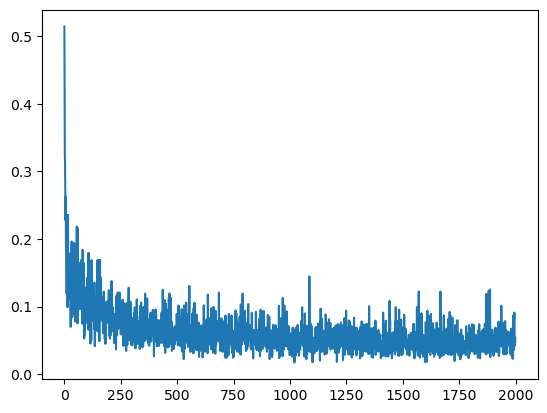

In [ ]:
# generate data
torch.manual_seed(0)
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(x_train, dtype=torch.float32).unsqueeze(1),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    ),
    batch_size=20, shuffle=False
)
dropout_net = MLP(*DIMENSIONS, output_type="numeric", dropout_rate=0.2)
dropout_net.train(
    train_loader, n_epochs=EPOCHS, lr=LR, weight_decay=WD,
    milestones=[2000], gamma=1, # turn off learning rate decay
    seed=1, log_interval=100
)

### Plot

100%|██████████| 1000/1000 [00:00<00:00, 2470.99it/s]


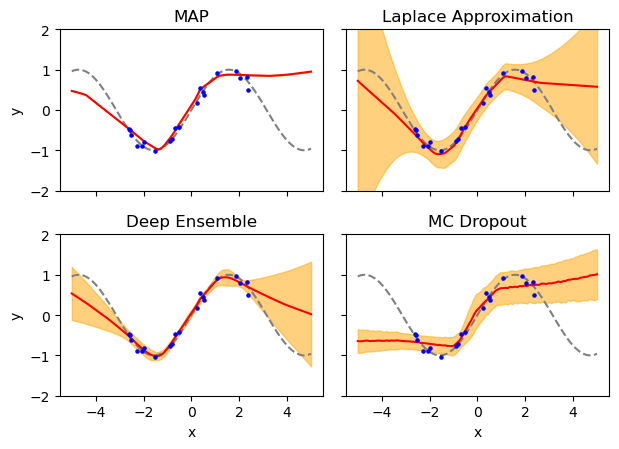

In [94]:
# plot
def plot_regr(ax, x_train, y_train, x_test, mean, std):
    ax.plot(x_test, regr_true_func(x_test), color="grey", linestyle="--")
    ax.scatter(x_train, y_train, color="blue", s=5, zorder=10)
    ax.plot(x_test, mean, color="red")
    ax.fill_between(x_test, mean+2*std, mean-2*std, alpha=0.5, color="orange")
    ax.set_ylim(-2, 2)

fig, ax = plt.subplots(2, 2, figsize=(6.3,4.6), layout="tight", sharex="all", sharey="all")
x_test = np.linspace(-5, 5, 100)
x_test_tensor = torch.as_tensor(x_test, dtype=torch.float32, device=device).reshape(-1, 1)

# MAP
y_map = net.predict(x_test_tensor).squeeze()
plot_regr(ax[0,0], x_train, y_train, x_test, y_map, 0)
ax[0,0].set_title("MAP")
ax[0,0].set_ylabel("y")

# LA
mean, std = la(x_test_tensor, pred_type="glm")
mean = mean.cpu().numpy().squeeze()
std = std.cpu().numpy().squeeze()
plot_regr(ax[0,1], x_train, y_train, x_test, mean, std)
ax[0,1].set_title("Laplace Approximation")

# Ensemble
ensemble_preds = []
for net in ensemble:
    ensemble_preds.append(net.predict(x_test_tensor).squeeze())
ensemble_preds = np.stack(ensemble_preds)
mean = ensemble_preds.mean(axis=0)
std = ensemble_preds.std(axis=0)
plot_regr(ax[1,0], x_train, y_train, x_test, mean, std)
ax[1,0].set_title("Deep Ensemble")
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")

# Dropout
n_mc_samples = 1000
mcd_preds = []
for _ in tqdm(range(n_mc_samples)):
    mcd_preds.append(dropout_net.predict(x_test_tensor, mc_dropout=True).squeeze())
mcd_preds = np.stack(mcd_preds)
mean = mcd_preds.mean(axis=0)
std = mcd_preds.std(axis=0)
plot_regr(ax[1,1], x_train, y_train, x_test, mean, std)
ax[1,1].set_title("MC Dropout")
ax[1,1].set_xlabel("x")

# plt.savefig("../thesis/images/regr_comparison.pdf")
plt.show()